# **1. 데이터 차원**
- 데이터 자체는 충분함
- 불균형 데이터 -> Data Augmentation/ One-shot Learning
- 데이터 범위(scale) 조정: 정규화/규제화/표준화

# **2. 알고리즘 차원**
- 진단
    - train/ valid 모두 accuracy가 그다지 높지 않음 -> Epoch을 증가시켜 다시 학습 진행 
    - 과적합 방지를 위한 기법들 도입하기(드롭아웃, 조기 종료)
- 가중치
    - AutoEncoder 등과 같은 비지도 학습을 통해 사전 훈련
    - 이후 다시 지도 학습 진행
- 학습률(learning rate)
    - Learning rate Scheduling 적용
- 활성화 함수/손실함수
    - 활성화 함수: softmax
    - 손실 함수: CrossEntropyLoss
    - 활성화 함수 변경 시 손실 함수도 함께 변경해야 하는 경우가 많음 -> 주의
- 배치/ Epoch
    - DataLoader에서 batch size 조정(batch_size = 32 or 64) --- ?
    - Epoch: 과소적합의 경향성 -> 100으로 증가

# **3. 하드웨어 차원**
- 역전파처럼 복잡한 미적분 연산의 경우 병렬 연산을 해야 속도/ 정확도 증가
- 장치를 cpu에서 gpu로 변경

In [2]:
### 필요한 라이브러리 준비

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import copy
import argparse

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from ipywidgets import interact
from module.pytorchtools import EarlyStopping # 사용자 정의 모듈
                                              # 외부 py파일을 모듈로 import하여 EarlyStopping 함수 사용

In [4]:
### gpu 장치 확인
print(torch.__version__) 
print(torch.cuda.get_device_name(0))

1.12.1+cu116
NVIDIA GeForce GTX 1660 SUPER


### **DataLoader**

In [5]:
train_data_dir = './DataSet/archive/train/'
train_data_df = pd.read_csv(os.path.join(train_data_dir,'train.csv'))

# 분류에 사용할 class 정의(7개의 감정들)
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [6]:
IMAGE_SIZE = 48

### 이미지 파일 경로를 리스트 형태로 저장하기 위한 함수
def list_image_file(data_dir,sub_dir):
    image_files = []
    
    images_dir = os.path.join(data_dir,sub_dir)
    for file_path in os.listdir(images_dir):
        image_files.append(os.path.join(sub_dir,file_path))
    return image_files

In [7]:
### 학습 데이터셋 클래스
class Feeling_dataset(Dataset):
    ### 생성자
    def __init__(self,data_dir,transform = None):
        self.data_dir = data_dir # 데이터가 저장된 상위 directory
        angry_imgs = list_image_file(data_dir,'angry')
        disgust_imgs = list_image_file(data_dir,'disgust')
        fear_imgs = list_image_file(data_dir,'fear')
        happy_imgs = list_image_file(data_dir,'happy')
        neutral_imgs = list_image_file(data_dir,'neutral')
        sad_imgs = list_image_file(data_dir,'sad')
        surprise_imgs = list_image_file(data_dir,'surprise')
        
        # 모든 사진들의 경로를 하나의 리스트에 저장
        self.files_path = angry_imgs + disgust_imgs + fear_imgs + happy_imgs + neutral_imgs + sad_imgs + surprise_imgs
        self.transform = transform
    
    ### 데이터 개수 확인
    def __len__(self):
        return len(self.files_path) # 전체 데이터 개수
    
    ### getitem
    def __getitem__(self,index):
        # image(feature data)
        image_file = os.path.join(self.data_dir,self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.resize(image,dsize = (IMAGE_SIZE,IMAGE_SIZE),interpolation = cv2.INTER_LINEAR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        # feeling(target data)
        target = feelings_list.index(self.files_path[index].split(os.sep)[0])
        
        if self.transform:
            image = self.transform(image) # feature data에 대해서만 데이터 변형 수행
            target = torch.Tensor([target]).long()
            
        return {'image':image,'target':target}

In [8]:
### Transformation

# 학습 feature data 변환
train_transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # 수평으로 뒤집기
    transforms.RandomVerticalFlip(), # 수직으로 뒤집기
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

# 검증 feature data 변환
val_transformer = transforms.Compose([
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

In [10]:
### 데이터로더 구현
def build_dataloader(train_data_dir,val_data_dir):
    dataloaders = {}
    train_dset = Feeling_dataset(train_data_dir,train_transformer)
    dataloaders['train'] = DataLoader(train_dset,batch_size = 64,shuffle = True,drop_last = True)
    
    val_dset = Feeling_dataset(val_data_dir,val_transformer)
    dataloaders['val'] = DataLoader(val_dset,batch_size = 64,shuffle = False,drop_last = False)
    
    return dataloaders

- batch size 조정 필요

In [11]:
train_data_dir = './DataSet/archive/train/'
val_data_dir = train_data_dir = './DataSet/archive/valid/'
dataloaders = build_dataloader(train_data_dir,val_data_dir)

### **Modeling**

In [12]:
from torchsummary import summary

In [13]:
### 모델 생성 함수
# 기존의 VGG19 모델 호출 -> head 부분 수정
def build_vgg19_based_model():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = models.vgg19(pretrained = True) # 이미 학습된 vgg19 모델 불러오기
    # 일반 NN Layer(FC Layer)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size = (1,1)) # 각 구역의 평균값 출력
    model.classifier = nn.Sequential(
        nn.Flatten(), # 평탄화
        nn.Linear(512,256), # 512 -> 256
        nn.ReLU(), # 활성화 함수
        nn.Dropout(0.1), # 과적합 방지
        nn.Linear(256,7), # 256 -> 7(7개의 감정으로 분류되니)
        nn.Softmax() # 활성화 함수(각 클래스에 속할 확률 추정)
    )
    
    return model.to(device)

### **Estimation**

In [14]:
### 모델 검증을 위한 accuracy

@torch.no_grad() 
def get_accuracy(image,target,model):
    batch_size = image.shape[0] 
    prediction = model(image) # 예측 
    _,pred_label = torch.max(prediction,dim = 1) # 예측이 어느 클래스에 속하는지 확률이 가장 높은 1개 선택
    is_correct = (pred_label == target)
    
    return is_correct.cpu().numpy().sum() / batch_size

### **Training**

In [15]:
### Epoch을 1번 수행
def train_one_epoch(dataloaders,model,optimizer,loss_func,device):
    losses = {} # loss값 저장
    accuracies = {} # 정확도 값 저장
    
    for tv in ['train','val']:
        ### loss, accuracy를 계속 갱신
        running_loss = 0.0
        running_correct = 0
        
        if tv == 'train': # 학습
            model.train()
        else: # 검증
            model.eval()
        
        for index,batch in enumerate(dataloaders[tv]):
            image = batch['image'].to(device) # feature data(이미지)
            target = batch['target'].squeeze(dim = 1).to(device) # label data(감정), 1차원으로 차원 축소 진행
            
            ### 역전파 적용
            with torch.set_grad_enabled(tv == 'train'): 
                prediction = model(image) # label 예측
                loss = loss_func(prediction,target) # loss값 계산
                
                if tv == 'train':
                    optimizer.zero_grad() # 한 번의 학습 완료 -> gradient를 0으로 초기화
                    loss.backward() # 역전파
                    optimizer.step() # 가중치 업데이트
                    
            running_loss += loss.item()
            running_correct += get_accuracy(image,target,model)
            
            if tv == 'train':
                if index % 50 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
        losses[tv] = running_loss / len(dataloaders[tv])
        accuracies[tv] = running_correct / len(dataloaders[tv])
    return losses, accuracies

In [16]:
### 학습이 잘 된 모델 저장
def save_best_model(model_state,model_name,save_dir = './best_model'):
    os.makedirs(save_dir,exist_ok = True) # 경로 존재 시 덮어쓰기, 없는 경우 새로 생성
    torch.save(model_state,os.path.join(save_dir,model_name)) # 모델 저장

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 장치 얻어오기

### 경로 설정
train_data_dir = './DataSet/archive/train/'
val_data_dir = './DataSet/archive/valid/'

### 필요한 요소들 준비
dataloaders = build_dataloader(train_data_dir,val_data_dir)
model = build_vgg19_based_model()
loss_func = nn.CrossEntropyLoss(reduction = 'mean')
optimizer = torch.optim.SGD(model.parameters(),lr = 1E-3,momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 5, factor = 0.1,
                                                       min_lr = 1e-6,verbose = True)  # lr scheduling
early_stopping = EarlyStopping(patience = 5, verbose = False) # 조기 종료(사용자 정의 모듈)

c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
num_epochs = 100

best_acc = 0.0
train_loss,train_accuracy = [],[]
val_loss,val_accuracy = [],[]

for epoch in range(num_epochs):
    ### 1 Epoch 수행
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    
    ### LR Scheduling
    scheduler.step(losses['val']) # 1 Epoch 수행 후 learning rate 조정
    # EarlyStopping
    early_stopping(losses['val'], model) # 현재 과적합 상황 추적
    if early_stopping.early_stop: # 조건 만족 시 조기 종료
        break
        
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])
    train_accuracy.append(accuracies['train'])
    val_accuracy.append(accuracies['val'])
    
    print(f"{epoch+1}/{num_epochs}-Train Loss:{losses['train']}, Val Loss:{losses['val']}")
    print(f"{epoch+1}/{num_epochs}-Train Acc:{accuracies['train']}, Val Acc:{accuracies['val']}")
    
    # deepcopy: 배열의 내부 객체까지 복사를 해서 사용
    # copy: 배열의 내부 객체까지 깊은 복사를 해주지 않음
    if (epoch > 3) and (accuracies['val'] > best_acc):
        best_acc = accuracies['val']
        best_model = copy.deepcopy(model.state_dict()) 
        save_best_model(best_model, f'model_{epoch+1:02d}.pth')

print(f'Bset Accuracy: {best_acc}')

c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0/455 - Running loss: 1.9503206014633179
50/455 - Running loss: 1.9119274616241455
100/455 - Running loss: 1.8734538555145264
150/455 - Running loss: 1.8169291019439697
200/455 - Running loss: 1.7869939804077148
250/455 - Running loss: 1.7097833156585693
300/455 - Running loss: 1.649154782295227
350/455 - Running loss: 1.8048381805419922
400/455 - Running loss: 1.611164927482605
450/455 - Running loss: 1.7375844717025757
1/100-Train Loss:1.793736319227533, Val Loss:1.7048838159494233
1/100-Train Acc:0.3672733516483517, Val Acc:0.45222829319060365
0/455 - Running loss: 1.7125935554504395
50/455 - Running loss: 1.6925249099731445
100/455 - Running loss: 1.805444598197937
150/455 - Running loss: 1.704027533531189
200/455 - Running loss: 1.6701912879943848
250/455 - Running loss: 1.6734379529953003
300/455 - Running loss: 1.7406787872314453
350/455 - Running loss: 1.82059645652771
400/455 - Running loss: 1.8130155801773071
450/455 - Running loss: 1.7298357486724854
2/100-Train Loss:1.69971

450/455 - Running loss: 1.5708379745483398
EarlyStopping counter: 2 out of 5
15/100-Train Loss:1.5562788177322555, Val Loss:1.592082374974301
15/100-Train Acc:0.6219093406593407, Val Acc:0.5671043339280404
0/455 - Running loss: 1.5474703311920166
50/455 - Running loss: 1.4714386463165283
100/455 - Running loss: 1.6142702102661133
150/455 - Running loss: 1.5501477718353271
200/455 - Running loss: 1.3905396461486816
250/455 - Running loss: 1.5406206846237183
300/455 - Running loss: 1.55992591381073
350/455 - Running loss: 1.6544709205627441
400/455 - Running loss: 1.5523464679718018
450/455 - Running loss: 1.6088124513626099
16/100-Train Loss:1.5509124664159921, Val Loss:1.5821883406555444
16/100-Train Acc:0.6281936813186814, Val Acc:0.5764523862622659
0/455 - Running loss: 1.5286213159561157
50/455 - Running loss: 1.6089086532592773
100/455 - Running loss: 1.4889049530029297
150/455 - Running loss: 1.483036756515503
200/455 - Running loss: 1.664994716644287
250/455 - Running loss: 1.521

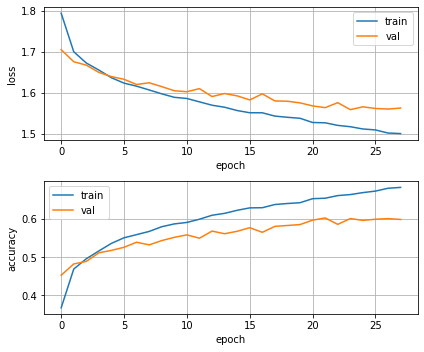

In [20]:
### Loss, Accuracy 시각화

plt.figure(figsize = (6,5))

# Loss
plt.subplot(211)
plt.plot(train_loss,label = "train")
plt.plot(val_loss,label = "val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()

# Accuracy
plt.subplot(212)
plt.plot(train_accuracy,label = "train")
plt.plot(val_accuracy,label = "val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid("on")
plt.legend()

plt.tight_layout()